# Model Training Notebook for Benchmark Simple MLP

This notebook is dedicated to training a simple MLP model focusing on longitudinal predictions in Alzheimer's disease progression. More specifically, the model is training to predict baseline cognition. This is done through the use of baseline regional tau data. This notebook covers:

>Note: This notebook trains on the same patients as the LSTM model! Visit the `training_bench_full.ipynb` to run the training on a larger dataset. 

### Data Preprocessing 
- Loading 
- Normalization
- Formatting
- Splitting

### Model Training
- Data conversion into tensors and datasets 
- K-fold cross validation 
- Training
- Loss curve plotting

### Model Analysis
- Correlation analysis 
- Prediction accuracy 

In [3]:
import pandas as pd 
import numpy as np
import mat4py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from model import SimpleMLP

#### Load in data pre-processed data from LSTM training, before being split 

In [4]:
lstm_data = pd.read_csv('../data/pre_split.csv')


In [6]:
data = pd.read_csv('../data/Tau_with_Demographics.csv')
data

,merge_RID,MMSE_bl,ADAS11_bl,ADAS13_bl,merge_DX,best_DX,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,ctx-rh-cuneus,...,W_average_tau,W_average_frontal,W_average_temporal,W_average_parietal,W_average_occipital,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,Unnamed: 127
0,21,30,6.67,9.67,CN,CN,1.2475,1.0892,1.0955,1.1562,...,-0.046907,0.339853,1.036789,0.601625,1.100572,0.0,1.0,3.0,0.166798,NaN
1,31,30,1.67,1.67,CN,CN,1.1139,1.1076,1.0328,1.0991,...,-0.109110,0.414346,0.930375,0.573440,0.406073,0.0,1.0,4.0,0.149829,NaN
2,31,30,1.67,1.67,CN,CN,1.0569,1.0586,1.0009,1.0735,...,-0.099811,0.414346,0.930375,0.573440,0.406073,0.0,1.0,4.0,0.149857,NaN
3,56,28,3.00,3.00,MCI,EMCI,1.2538,1.1106,1.1190,1.1746,...,-0.009005,0.676851,0.821165,0.721422,1.261718,0.0,1.0,4.0,0.149921,NaN
4,56,28,3.00,3.00,MCI,EMCI,1.2577,1.1456,1.1177,1.1838,...,0.008748,0.676851,0.821165,0.721422,1.261718,0.0,1.0,4.0,0.150014,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,6704,28,10.33,14.33,CN,SMC,1.2162,1.0774,1.0614,1.0889,...,-0.087506,1.535122,1.152178,0.608225,1.467432,0.0,1.0,6.0,0.168199,NaN
815,6705,25,19.33,27.33,Dementia,AD,1.1079,0.9254,0.9342,0.9448,...,-0.150065,0.368088,0.194553,0.006670,-0.165769,0.0,1.0,10.0,0.375510,NaN
816,6713,27,19.00,29.00,Dementia,AD,1.0330,0.8888,0.9048,0.9494,...,0.062978,-0.077413,-0.294780,-0.816025,-0.392363,0.0,1.0,0.0,0.201921,NaN
817,6721,25,19.67,29.67,Dementia,AD,1.2617,1.1233,1.0587,1.1351,...,0.005101,0.156117,-0.058634,0.073827,0.219533,0.0,1.0,10.0,NaN,NaN


In [7]:
# check which columns have nan values
data.isnull().sum()

merge_RID            0
MMSE_bl              0
ADAS11_bl            4
ADAS13_bl            5
merge_DX             0
                  ... 
ml_subtype           6
prob_ml_subtype      6
ml_stage             6
prob_ml_stage        6
Unnamed: 127       819
Length: 128, dtype: int64

In [8]:
# row that has nan adascog
data[data['ADAS11_bl'].isnull()]

,merge_RID,MMSE_bl,ADAS11_bl,ADAS13_bl,merge_DX,best_DX,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,ctx-rh-cuneus,...,W_average_tau,W_average_frontal,W_average_temporal,W_average_parietal,W_average_occipital,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,Unnamed: 127
262,4513,29,NaN,NaN,CN,EMCI,1.1629,0.9897,0.9684,1.1032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.439651,NaN
263,4513,29,NaN,NaN,CN,EMCI,1.1196,0.9917,0.9591,1.0357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.209511,NaN
454,6038,30,NaN,NaN,CN,SMC,1.1116,0.9923,1.0562,1.0961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455,6038,30,NaN,NaN,CN,SMC,1.0535,0.9316,1.0102,1.0626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data = data.dropna(subset=['ADAS11_bl'])

In [10]:
data.columns

Index(['merge_RID', 'MMSE_bl', 'ADAS11_bl', 'ADAS13_bl', 'merge_DX', 'best_DX',
       'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate',
       'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',
       ...
       'W_average_tau', 'W_average_frontal', 'W_average_temporal',
       'W_average_parietal', 'W_average_occipital', 'ml_subtype',
       'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'Unnamed: 127'],
      dtype='object', length=128)

In [11]:
# one hot encode categorical columns 
data.drop(columns=['merge_RID', 'ADAS13_bl', 'merge_DX', 'best_DX', 'best_DX.1', 'RID.1', 'Diagnosis', 'ADAS11_bl.1', 'ADAS13_bl.1', 'merge_DX.1', 'merge_RID.1', 'MMSE_bl.1', 'W_average_hippo', 'W_average_tau', 'W_average_frontal', 'W_average_temporal', 'W_average_parietal', 'W_average_occipital', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'Unnamed: 127', 'Unnamed: 0', 'W_ADAS11', 'APOE4', 'FDG', 'PIB', 'AV45', 'ABETA', 'TAU', 'CDRSB'], inplace=True)

/tmp/ipykernel_515/1231390343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['merge_RID', 'ADAS13_bl', 'merge_DX', 'best_DX', 'best_DX.1', 'RID.1', 'Diagnosis', 'ADAS11_bl.1', 'ADAS13_bl.1', 'merge_DX.1', 'merge_RID.1', 'MMSE_bl.1', 'W_average_hippo', 'W_average_tau', 'W_average_frontal', 'W_average_temporal', 'W_average_parietal', 'W_average_occipital', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'Unnamed: 127', 'Unnamed: 0', 'W_ADAS11', 'APOE4', 'FDG', 'PIB', 'AV45', 'ABETA', 'TAU', 'CDRSB'], inplace=True)


In [12]:
data

,MMSE_bl,ADAS11_bl,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,ctx-rh-cuneus,ctx-rh-entorhinal,ctx-rh-fusiform,ctx-rh-inferiorparietal,ctx-rh-inferiortemporal,...,Right-Accumbens-area,Right-VentralDC,RID,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,PTAU
0,30,6.67,1.2475,1.0892,1.0955,1.1562,1.1607,1.2316,1.1644,1.3261,...,1.3873,1.3700,21,72.6,Female,18,Not Hisp/Latino,Black,Divorced,NaN
1,30,1.67,1.1139,1.1076,1.0328,1.0991,1.2740,1.1573,1.0765,1.1192,...,1.2469,1.2306,31,77.7,Female,18,Not Hisp/Latino,White,Widowed,22.55
2,30,1.67,1.0569,1.0586,1.0009,1.0735,1.2171,1.1320,1.0301,1.0547,...,1.1791,1.1674,31,77.7,Female,18,Not Hisp/Latino,White,Widowed,22.55
3,28,3.00,1.2538,1.1106,1.1190,1.1746,1.2623,1.2372,1.1783,1.2294,...,1.2582,1.3548,56,69.6,Female,13,Not Hisp/Latino,Black,Widowed,12.23
4,28,3.00,1.2577,1.1456,1.1177,1.1838,1.2191,1.2115,1.1928,1.2174,...,1.2479,1.3791,56,69.6,Female,13,Not Hisp/Latino,Black,Widowed,12.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,28,10.33,1.2162,1.0774,1.0614,1.0889,1.0830,1.1557,1.1285,1.1715,...,1.1515,1.2648,6704,65.3,Female,12,Hisp/Latino,White,Married,NaN
815,25,19.33,1.1079,0.9254,0.9342,0.9448,1.0273,1.0828,1.0061,1.0655,...,1.1304,1.1523,6705,74.9,Male,18,Not Hisp/Latino,White,Married,NaN
816,27,19.00,1.0330,0.8888,0.9048,0.9494,1.4117,1.1786,1.0054,1.2203,...,1.1515,1.1213,6713,71.1,Female,16,Not Hisp/Latino,White,Married,NaN
817,25,19.67,1.2617,1.1233,1.0587,1.1351,1.2295,1.2434,1.1906,1.2705,...,1.4672,1.4012,6721,77.9,Male,18,Not Hisp/Latino,White,Married,NaN


In [14]:
# merge both dataframes together
data = pd.merge(lstm_data, data, left_on='pid', right_on='RID')

data

,pid,xsol,DX_bl,AGE_x,PTGENDER_x,PTEDUCAT_x,PTMARRY_x,ADAS11_bl_x,APOE4,MMSE_bl_x,...,Right-Accumbens-area,Right-VentralDC,RID,AGE_y,PTGENDER_y,PTEDUCAT_y,PTETHCAT,PTRACCAT,PTMARRY_y,PTAU
0,112,"[[0.0, 1.5154876748982818e-10, 9.7067880966823...",LMCI,70.6,Male,18,Married,6.00,1.0,30,...,1.3791,1.2399,112,70.6,Male,18,Not Hisp/Latino,White,Married,24.43
1,112,"[[0.0, 1.5154876748982818e-10, 9.7067880966823...",LMCI,70.6,Male,18,Married,6.00,1.0,30,...,1.4727,1.3237,112,70.6,Male,18,Not Hisp/Latino,White,Married,24.43
2,112,"[[0.0, 1.5154876748982818e-10, 9.7067880966823...",LMCI,70.6,Male,18,Married,6.00,1.0,30,...,1.3665,1.2119,112,70.6,Male,18,Not Hisp/Latino,White,Married,24.43
3,142,"[[0.0, 6.320626952342735e-13, 7.79590773551454...",LMCI,79.2,Male,14,Widowed,7.33,1.0,29,...,1.5260,1.2730,142,79.2,Male,14,Not Hisp/Latino,White,Widowed,NaN
4,416,"[[0.0, 1.5549218134933345e-11, 1.3265144894746...",CN,75.6,Female,14,Married,3.00,0.0,29,...,1.1041,1.1613,416,75.6,Female,14,Not Hisp/Latino,White,Married,21.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,6606,"[[0.0, 1.487141624971677e-11, 1.73003944730773...",LMCI,73.6,Female,16,Married,14.67,1.0,26,...,2.1131,1.8093,6606,73.6,Female,16,Not Hisp/Latino,White,Married,NaN
274,6632,"[[0.0, 3.2286433106663908e-12, 2.1390054569148...",LMCI,74.5,Female,14,Married,23.00,1.0,22,...,1.5854,1.1197,6632,74.5,Female,14,Not Hisp/Latino,White,Married,NaN
275,6634,"[[0.0, 3.445735874145771e-12, 3.54441244207998...",LMCI,80.3,Female,16,Married,16.33,0.0,28,...,1.1688,1.2514,6634,80.3,Female,16,Not Hisp/Latino,White,Married,NaN
276,6641,"[[0.0, 2.1434095037216448e-11, 1.6025587426862...",LMCI,64.9,Male,16,Married,10.67,1.0,29,...,1.4932,1.4468,6641,64.9,Male,16,Not Hisp/Latino,White,Married,NaN


In [15]:
# select Y values (cognitive scores ADAS11 and MMSE)
cog_scores = data.iloc[:, 10:12]
cog_scores

,MMSE_bl_y,ADAS11_bl_y
0,30,6.00
1,30,6.00
2,30,6.00
3,29,7.33
4,29,3.00
...,...,...
273,26,16.67
274,22,26.00
275,28,19.33
276,29,12.67


In [16]:
# select X values (baseline tau across 86 regions)
baseline_tau = data.iloc[:, 12:98]
baseline_tau

,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,ctx-rh-cuneus,ctx-rh-entorhinal,ctx-rh-fusiform,ctx-rh-inferiorparietal,ctx-rh-inferiortemporal,ctx-rh-isthmuscingulate,ctx-rh-lateraloccipital,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
0,1.4026,1.1577,1.3012,1.2096,1.3251,1.3350,1.2132,1.4321,1.2615,0.9778,...,1.2866,0.9549,1.2376,1.0908,1.5861,1.6214,1.4145,1.6021,1.3791,1.2399
1,1.3675,1.1803,1.4579,1.2044,1.4332,1.4180,1.2428,1.4814,1.3474,1.0259,...,1.3392,0.9961,1.3620,1.0821,1.7641,1.7924,1.4646,1.7082,1.4727,1.3237
2,1.4488,1.1850,1.4609,1.2169,1.4261,1.4203,1.2296,1.5191,1.2943,1.0064,...,1.2681,0.9765,1.2560,0.9745,1.7145,1.6972,1.3895,1.6999,1.3665,1.2119
3,1.1808,1.0478,0.9863,1.0776,1.1446,1.1341,1.0572,1.2831,1.1453,1.0573,...,1.2537,1.0122,1.1625,1.0439,1.5689,1.6537,1.0626,1.4814,1.5260,1.2730
4,1.1537,1.0208,1.0463,1.0855,1.1887,1.1892,1.0922,1.2366,1.0126,1.1718,...,1.1316,0.9987,1.2907,1.0444,1.4531,1.5331,1.4753,1.2462,1.1041,1.1613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,2.1107,1.9117,1.8302,1.3479,2.6533,2.2048,1.6910,2.8939,1.7158,1.5097,...,1.7483,1.1260,1.6121,1.6580,2.4124,2.3897,2.3725,2.8827,2.1131,1.8093
274,1.9437,1.2971,1.3160,1.2300,1.7065,2.3544,1.6652,2.5078,1.6451,1.6068,...,1.1327,1.0548,1.0498,1.1335,1.4214,1.3672,1.3780,1.4593,1.5854,1.1197
275,1.3378,0.7886,1.0131,1.4612,1.5159,1.4526,1.2797,1.3156,1.2020,1.4725,...,1.2801,1.0148,1.2702,0.9202,1.5060,1.6095,1.6482,1.4138,1.1688,1.2514
276,1.3749,1.2017,1.3082,1.1528,1.6150,1.4119,1.4809,1.5179,1.3419,1.1228,...,1.4792,0.9996,1.2417,1.0564,1.6301,1.8491,1.5108,1.7322,1.4932,1.4468


In [17]:
# combine all columns in baseline tau into one column as an np array
baseline_tau = baseline_tau.apply(lambda x: np.array(x), axis=1)
baseline_tau


0      [1.4026, 1.1577, 1.3012, 1.2096, 1.3251, 1.335...
1      [1.3675, 1.1803, 1.4579, 1.2044, 1.4332, 1.418...
2      [1.4488, 1.185, 1.4609, 1.2169, 1.4261, 1.4203...
3      [1.1808, 1.0478, 0.9863, 1.0776, 1.1446, 1.134...
4      [1.1537, 1.0208, 1.0463, 1.0855, 1.1887, 1.189...
                             ...                        
273    [2.1107, 1.9117, 1.8302, 1.3479, 2.6533, 2.204...
274    [1.9437, 1.2971, 1.316, 1.23, 1.7065, 2.3544, ...
275    [1.3378, 0.7886, 1.0131, 1.4612, 1.5159, 1.452...
276    [1.3749, 1.2017, 1.3082, 1.1528, 1.615, 1.4119...
277    [1.1912, 0.9941, 1.071, 1.1323, 1.1564, 1.1797...
Length: 278, dtype: object

In [18]:
# normalize ADAS11 and MMSE

adas11_mean = cog_scores['ADAS11_bl_y'].mean()
adas11_std = cog_scores['ADAS11_bl_y'].std()

mmse_mean = cog_scores['MMSE_bl_y'].mean()
mmse_std = cog_scores['MMSE_bl_y'].std()

cog_scores['ADAS11_bl_y'] = (cog_scores['ADAS11_bl_y'] - adas11_mean) / adas11_std
cog_scores['MMSE_bl_y'] = (cog_scores['MMSE_bl_y'] - mmse_mean) / mmse_std


cog_scores

,MMSE_bl_y,ADAS11_bl_y
0,0.902693,-0.689750
1,0.902693,-0.689750
2,0.902693,-0.689750
3,0.449717,-0.436738
4,0.449717,-1.260453
...,...,...
273,-0.909211,1.340050
274,-2.721116,3.114936
275,-0.003259,1.846073
276,0.449717,0.579113


In [19]:
X = baseline_tau.values
y = cog_scores[['ADAS11_bl_y', 'MMSE_bl_y']].values


### Prepare data for training

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape



(torch.Size([194, 86]),
 torch.Size([194, 2]),
 torch.Size([84, 86]),
 torch.Size([84, 2]))

### Training

In [21]:
# import kfold
from sklearn.model_selection import KFold

#import SubsetRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler

In [22]:
# kfold cross validation
k = 5
num_epochs = 100
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_train_losses = []
fold_val_losses = []
best_fold = None
min_val_loss = float('inf')

for fold, (train_ids, val_ids) in enumerate(kf.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_subsampler = SubsetRandomSampler(train_ids)
    val_subsampler = SubsetRandomSampler(val_ids)
    
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_subsampler)
    
    model = SimpleMLP(86, [128, 64, 32], 2)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    training_loss  = []
    validation_loss = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for data in train_loader:
            inputs, targets = data  
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
        
        epoch_loss /= len(train_loader.dataset)
        training_loss.append(epoch_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs, targets = data
                outputs = model(inputs)
                loss = loss_function(outputs, targets)
                epoch_val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss /= len(val_loader.dataset)
        validation_loss.append(epoch_val_loss)

        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            best_fold = fold

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {epoch_loss:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f}')
    
    print('--------------------------------')
    fold_train_losses.append(training_loss)
    fold_val_losses.append(validation_loss)

    torch.save(model.state_dict(), f'../models/simple_mlp_fold{fold}_small.pth')

FOLD 0
--------------------------------


Epoch 1/100
Training Loss: 0.8105
Validation Loss: 0.1598
Epoch 2/100
Training Loss: 0.7997
Validation Loss: 0.1556
Epoch 3/100
Training Loss: 0.7909
Validation Loss: 0.1516
Epoch 4/100
Training Loss: 0.7799
Validation Loss: 0.1442
Epoch 5/100
Training Loss: 0.7653
Validation Loss: 0.1394
Epoch 6/100
Training Loss: 0.7793
Validation Loss: 0.1331
Epoch 7/100
Training Loss: 0.7402
Validation Loss: 0.1393
Epoch 8/100
Training Loss: 0.7459
Validation Loss: 0.1233
Epoch 9/100
Training Loss: 0.7272
Validation Loss: 0.1190
Epoch 10/100
Training Loss: 0.7130
Validation Loss: 0.1129
Epoch 11/100
Training Loss: 0.7172
Validation Loss: 0.1100
Epoch 12/100
Training Loss: 0.6927
Validation Loss: 0.1109
Epoch 13/100
Training Loss: 0.6981
Validation Loss: 0.1039
Epoch 14/100
Training Loss: 0.6800
Validation Loss: 0.0994
Epoch 15/100
Training Loss: 0.6715
Validation Loss: 0.1002
Epoch 16/100
Training Loss: 0.6731
Validation Loss: 0.0976
Epoch 17/100
Training Loss: 0.6706
Validation Loss: 0.0971
Epoch 

In [23]:
best_fold

0


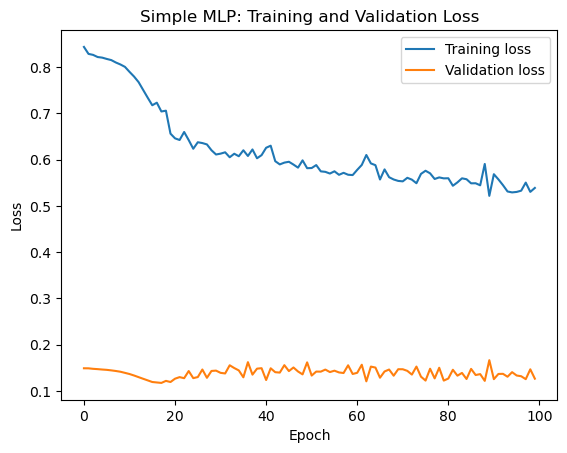

In [24]:
# plot best fold
import matplotlib.pyplot as plt

plt.plot(fold_train_losses[best_fold - 1], label='Training loss')
plt.plot(fold_val_losses[best_fold - 1], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Simple MLP: Training and Validation Loss')
plt.legend()
plt.show()

In [25]:
# load best fold
model.load_state_dict(torch.load(f'../models/simple_mlp_fold{best_fold}.pth'))
model.eval()

test_loader = DataLoader(test_dataset, batch_size=1)

# store predicted and true

predicted = []
true = []

with torch.no_grad():
    for data in test_loader:
        inputs, targets = data
        outputs = model(inputs)
        predicted.append(outputs)
        true.append(targets)

predicted[0][0][1]

tensor(-0.0734)

In [26]:
# unnormalize cog scores 
for p in predicted:
    p[0][0] = p[0][0] * adas11_std + adas11_mean
    p[0][1] = p[0][1] * mmse_std + mmse_mean

for t in true:
    t[0][0] = t[0][0] * adas11_std + adas11_mean
    t[0][1] = t[0][1] * mmse_std + mmse_mean



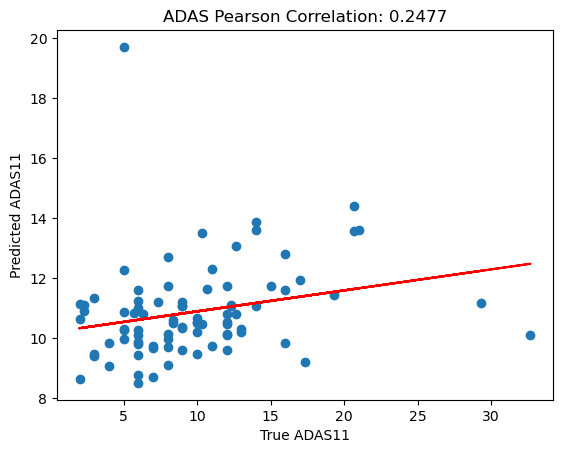

In [30]:
# plot correlations for adas 
predicted_adas = [p[0][0] for p in predicted]
true_adas = [t[0][0] for t in true]


pearson = np.corrcoef(true_adas, predicted_adas)
plt.scatter(true_adas, predicted_adas)
plt.xlabel('True ADAS11')
plt.ylabel('Predicted ADAS11')
plt.title(f'ADAS Pearson Correlation: {pearson[0][1]:.4f}')
m, b = np.polyfit(true_adas, predicted_adas, 1)
plt.plot(true_adas, m*np.array(true_adas) + b, color='red')

Text(0.5, 1.0, 'MMSE Pearson Correlation: 0.1222')

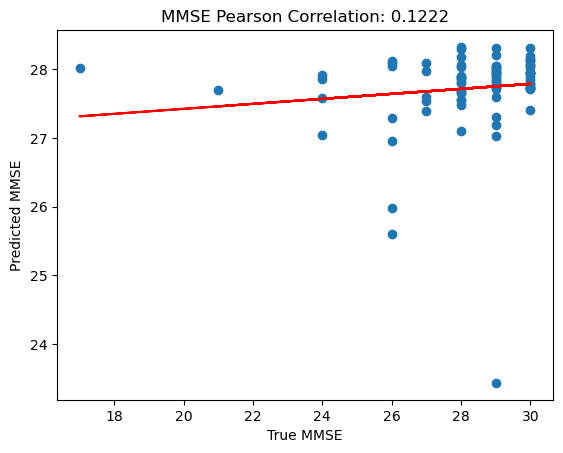

In [31]:
# plot correlations for mmse
predicted_mmse = [p[0][1] for p in predicted]
true_mmse = [t[0][1] for t in true]
pearson = np.corrcoef(true_mmse, predicted_mmse)
plt.scatter(true_mmse, predicted_mmse)
plt.xlabel('True MMSE')
plt.ylabel('Predicted MMSE')
m, b = np.polyfit(true_mmse, predicted_mmse, 1)
plt.plot(true_mmse, m*np.array(true_mmse) + b, color='red')
plt.title(f'MMSE Pearson Correlation: {pearson[0][1]:.4f}')


In [29]:
# pearson correlation
from scipy.stats import pearsonr

r, p = pearsonr(true_adas, predicted_adas)
print(f'Pearson correlation for ADAS11: {r:.4f}')

r, p = pearsonr(true_mmse, predicted_mmse)
print(f'Pearson correlation for MMSE: {r:.4f}')



Pearson correlation for ADAS11: 0.2477
Pearson correlation for MMSE: 0.1222
